# 0. Intro

#### This dataset provides us information about 150 000 users in train dataset. and our task is to predict probability of default ('SeriousDlqin2yrs' column).
link:
https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

#### This notebook includes:
- EDA with different visualizations.
- data preprocessing before using models.
- customers classification
- perform interpretation and analysis of classification that have been created.

### This notebook is SIMPLE solution and here we don't use:
- **optuna/bayesian algorithms for hyperparameters tuning (only GridSearchCV)** (will be implemented in **"credit scoring (gmsc) FE+Optuna"** notebook)
- **binning for variables (just scaling for linear model)** (will be implemented in **"credit scoring (gmsc) classic"** notebook)
- **advanced feature engineering (by creating new features from interactions between default features)** (will be implemented in **"classic"** and **FE+Optuna"** notebooks)

In [27]:
# Necessary libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20,15
import seaborn as sns
sns.set_palette(palette='viridis')

# df output optimization for cases if we want to print lots of data:
pd.set_option('display.notebook_repr_html', True)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 100)

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# 1. EDA

In [28]:
df=pd.read_csv('cs-training.csv')
df.tail()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0
149999,150000,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0


In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


So, we can notice that there are some variables with strange distribution with extralarge max values: 
- RevolvingUtilizationOfUnsecuredLines	
- DebtRatio
- MonthlyIncome	

strange, but questionable, currently we are not sure is it normal or not:
- NumberOfTimes90DaysLate
- NumberRealEstateLoansOrLines
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfTime30-59DaysPastDueNotWorse	

In [30]:
# data types checking
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [31]:
# missing values
df.isna().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [32]:
y = df['SeriousDlqin2yrs']
X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
X.head(2)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


In [39]:
print(y.value_counts(), '\n\nmean:', y.mean())

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64 

mean: 0.06684


#### We have unbalanced classes with minority class y=1. 

# 2. Data preprocessing before using models.

#### In this dataset we have several problems that should be solved:
- outliers
- missing values
- unbalanced classes
- optional (only for regression): feature scaling

In [99]:
# outliers and missing values (NaNs)
def outlier(X):
    q1 = X.quantile(0.01)
    q3 = X.quantile(0.99)
    iqr = q3-q1
    lqi = q1 #- 1.5*iqr
    hqi = q3 #+ 1.5*iqr 
    X[(X > hqi)| (X < lqi) ] = np.nan #
    X.isna().sum()
    X = X.fillna(X.median())  
    return X

#### Before transforming our variables we need to split train/test data

In [260]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [261]:
X_train = outlier(X_train)
X_test = outlier(X_test)

In [262]:
y_train.shape

(135000,)

In [263]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0


# 3. Models

In [192]:
! pip install lightgbm -q

In [107]:
# tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# boosting models
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, r2_score, confusion_matrix
from sklearn.metrics import classification_report

In [255]:
# parameters:
learning_rate = np.logspace(-8, 2, 11) 
cv=5
n_estimators = np.arange(20, 220, 10)
max_depth = np.arange(5,30, 5)
early_stopping_rounds = np.arange(2, 20, 1)

#### 3.1. Logistic Regression. Main advantage: interpretability

In [264]:
ss = StandardScaler()
X_train_s = pd.DataFrame(ss.fit_transform(X_train))
X_test_s = pd.DataFrame(ss.transform(X_test))

In [265]:
X_train_s.shape

(135000, 10)

In [266]:
%%time
grid={"C": np.logspace(-8, 2, 11) 
      ,"penalty":['none', 'l1', 'l2', 'elasticnet']
     , 'solver': ('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga')
    }# l1 lasso l2 ridge
logreg_cv=GridSearchCV(estimator=LogisticRegression(),
                           param_grid=grid, cv=5,
                            scoring='roc_auc', n_jobs=-1, verbose=10
                       
                           )
lr_cv = logreg_cv.fit(X_train_s,y_train)
y_pred = logreg_cv.predict(X_test_s)
roc_auc = roc_auc_score(y_pred, y_test)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("roc_auc train:",logreg_cv.best_score_, '\n',
     'roc_auc test:', roc_auc)

Fitting 5 folds for each of 264 candidates, totalling 1320 fits
tuned hpyerparameters :(best parameters)  {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
roc_auc train: 0.8481130500445607 
 roc_auc test: 0.7274515824176783
CPU times: total: 5.59 s
Wall time: 40.2 s


In [267]:
print(classification_report(y_pred, y_test), 'outliers boundaries 0,99/0,01')

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     14814
           1       0.10      0.52      0.16       186

    accuracy                           0.93     15000
   macro avg       0.54      0.73      0.56     15000
weighted avg       0.98      0.93      0.96     15000
 outliers boundaries 0,99/0,01


Text(120.72222222222221, 0.5, 'Ground Truth')

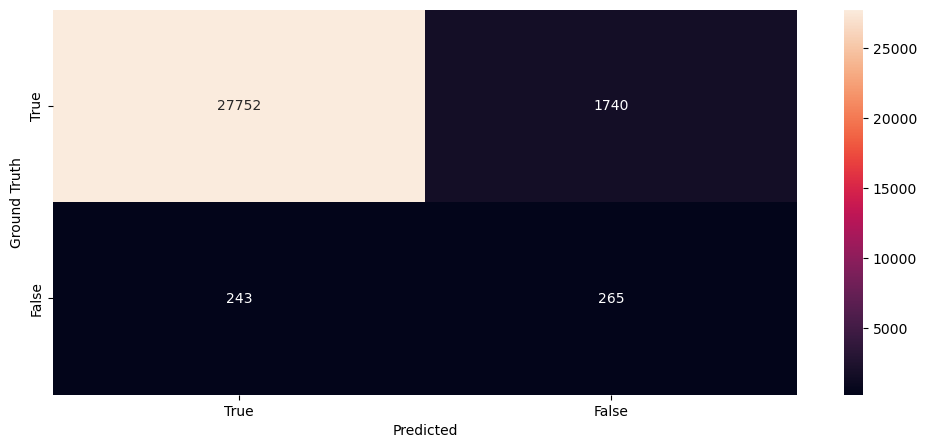

In [202]:
plt.figure(figsize=(12,5))
ax=sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')


labelsx=['True','False']
labels=['True','False']
ax.set_xticklabels(labelsx)
ax.set_yticklabels(labels)

ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')

In [205]:
#lr_cv.coef_, lr_cv.intercept_
coef = logreg_cv.best_estimator_.coef_
intercept = logreg_cv.best_estimator_.intercept_
coef = pd.DataFrame(coef).T
names = pd.DataFrame(X_train.columns)

interpretation = pd.concat([names, coef],axis=1)

interpretation.columns = ['Feature', 'Coefficient']
interpretation.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
0,RevolvingUtilizationOfUnsecuredLines,0.419209
6,NumberOfTimes90DaysLate,0.278841
2,NumberOfTime30-59DaysPastDueNotWorse,0.259048
8,NumberOfTime60-89DaysPastDueNotWorse,0.201589
5,NumberOfOpenCreditLinesAndLoans,0.081586
9,NumberOfDependents,0.034796
7,NumberRealEstateLoansOrLines,0.005006
3,DebtRatio,-0.046105
4,MonthlyIncome,-0.094917
1,age,-0.155549


#### 3.2. Random forest

In [143]:
%%time
parameters = {'n_estimators':
              n_estimators,  
              'max_depth': 
              max_depth
             }

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_g = GridSearchCV(estimator=rf, param_grid = parameters, cv = 5, n_jobs=-1, scoring='roc_auc')
model = rf_g.fit(X_train, y_train)
y_pred = model.predict(X_test);
print('roc_auc train:', model.best_score_)
print('roc_auc test:', roc_auc_score(y_pred, y_test))
print('parameters:', rf_g.best_params_)

roc_auc train: 0.8564801337932255
roc_auc test: 0.7520598016128875
parameters: {'max_depth': 10, 'n_estimators': 190}
CPU times: total: 48.8 s
Wall time: 19min 39s


In [144]:
print(classification_report(y_pred, y_test), 'outliers boundaries 0,99/0,01')

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     29612
           1       0.11      0.56      0.18       388

    accuracy                           0.93     30000
   macro avg       0.55      0.75      0.57     30000
weighted avg       0.98      0.93      0.96     30000
 outliers boundaries 0,99/0,01


In [240]:
from sklearn.inspection import permutation_importance
feature_names = [f"feature {i}" for i in range(X.shape[1])]
result = permutation_importance(rf_g, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
rf_g_importances = pd.Series(result.importances_mean, index=X_test.columns)
rf_g_importances = pd.DataFrame(rf_g_importances).reset_index()
rf_g_importances.columns = ['Feature', 'Importance']
rf_g_importances['Importance'] = rf_g_importances['Importance'] \
                                            /rf_g_importances['Importance'].sum()
rf_g_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,RevolvingUtilizationOfUnsecuredLines,0.358670
2,NumberOfTime30-59DaysPastDueNotWorse,0.198258
6,NumberOfTimes90DaysLate,0.180637
8,NumberOfTime60-89DaysPastDueNotWorse,0.122134
1,age,0.048302
3,DebtRatio,0.033543
5,NumberOfOpenCreditLinesAndLoans,0.031958
4,MonthlyIncome,0.014311
7,NumberRealEstateLoansOrLines,0.010171
9,NumberOfDependents,0.002015


 #### 3.3. Boosting

In [147]:
%%time
# LightGBM
lgbm = LGBMClassifier(verbose= -1)
parameters = {'learning_rate': learning_rate, 
                  'subsample'    : [0.9, 0.1],
                  'n_estimators' : n_estimators,
                  'max_depth'    : max_depth
            #  ,'early_stopping_rounds': early_stopping_rounds
                 }

grid_lgbm = GridSearchCV(estimator=lgbm, param_grid = parameters, cv = 5, scoring='roc_auc')
lgbm_grid = grid_lgbm.fit(X_train, y_train)
y_pred=lgbm_grid.predict(X_test);
print('roc_auc train:', lgbm_grid.best_score_)
print('roc_auc test:', roc_auc_score(y_pred, y_test))
print("\n The best parameters across ALL searched params:\n", grid_lgbm.best_params_)

roc_auc train: 0.8577578909455823
roc_auc test: 0.7462228227201325

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 70, 'subsample': 0.9}
CPU times: total: 2h 33min 46s
Wall time: 25min 38s


In [148]:
print('LightGBM', '\n', classification_report(y_pred, y_test), 'outliers boundaries 0,99/0,01')

LightGBM 
               precision    recall  f1-score   support

           0       0.99      0.94      0.97     29569
           1       0.12      0.55      0.20       431

    accuracy                           0.93     30000
   macro avg       0.56      0.75      0.58     30000
weighted avg       0.98      0.93      0.95     30000
 outliers boundaries 0,99/0,01


In [241]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
result = permutation_importance(lgbm_grid, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
lgbm_importances = pd.Series(result.importances_mean, index=X_test.columns)
lgbm_importances = pd.DataFrame(lgbm_importances).reset_index()
lgbm_importances.columns = ['Feature', 'Importance']
lgbm_importances['Importance'] = lgbm_importances['Importance'] \
                                            /lgbm_importances['Importance'].sum()
lgbm_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,RevolvingUtilizationOfUnsecuredLines,0.396241
2,NumberOfTime30-59DaysPastDueNotWorse,0.174122
6,NumberOfTimes90DaysLate,0.162304
8,NumberOfTime60-89DaysPastDueNotWorse,0.102739
1,age,0.059601
3,DebtRatio,0.045802
5,NumberOfOpenCreditLinesAndLoans,0.032849
4,MonthlyIncome,0.012297
7,NumberRealEstateLoansOrLines,0.010515
9,NumberOfDependents,0.003529


# 4. Final predictions

In [162]:
df_test=pd.read_csv('cs-test.csv')
df_test.tail()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
101498,101499,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,101500,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,101501,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,101502,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0
101502,101503,NaN,0.441842,29,0,0.198918,5916.0,12,0,0,0,0.0


In [163]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,101503.0,50752.000000,29301.536524,1.0,25376.500000,50752.000000,76127.500000,101503.0
SeriousDlqin2yrs,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevolvingUtilizationOfUnsecuredLines,101503.0,5.310000,196.156039,0.0,0.030131,0.152586,0.564225,21821.0
age,101503.0,52.405436,14.779756,21.0,41.000000,52.000000,63.000000,104.0
NumberOfTime30-59DaysPastDueNotWorse,101503.0,0.453770,4.538487,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,101503.0,344.475020,1632.595231,0.0,0.173423,0.364260,0.851619,268326.0
MonthlyIncome,81400.0,6855.035590,36508.600375,0.0,3408.000000,5400.000000,8200.000000,7727000.0
NumberOfOpenCreditLinesAndLoans,101503.0,8.453514,5.144100,0.0,5.000000,8.000000,11.000000,85.0
NumberOfTimes90DaysLate,101503.0,0.296691,4.515859,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,101503.0,1.013074,1.110253,0.0,0.000000,1.000000,2.000000,37.0


In [164]:
df_test.isna().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [180]:
X_tt = df_test.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)

In [193]:
# missing values (NaNs)
X_tt = X_tt.fillna(X_tt.median())
X_tt_s = ss.transform(X_tt)

In [194]:
X_tt.describe().T

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,101503.0,5.310000,196.156039,0.0,0.030131,0.152586,0.564225,21821.0
age,101503.0,52.405436,14.779756,21.0,41.000000,52.000000,63.000000,104.0
NumberOfTime30-59DaysPastDueNotWorse,101503.0,0.453770,4.538487,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,101503.0,344.475020,1632.595231,0.0,0.173423,0.364260,0.851619,268326.0
MonthlyIncome,101503.0,6566.861048,32699.094034,0.0,3900.000000,5400.000000,7374.000000,7727000.0
NumberOfOpenCreditLinesAndLoans,101503.0,8.453514,5.144100,0.0,5.000000,8.000000,11.000000,85.0
NumberOfTimes90DaysLate,101503.0,0.296691,4.515859,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,101503.0,1.013074,1.110253,0.0,0.000000,1.000000,2.000000,37.0
NumberOfTime60-89DaysPastDueNotWorse,101503.0,0.270317,4.503578,0.0,0.000000,0.000000,0.000000,98.0
NumberOfDependents,101503.0,0.749150,1.128600,0.0,0.000000,0.000000,1.000000,43.0


In [195]:
submission = pd.read_csv('sampleEntry.csv')

#### 4.1. Logistic Regression Submission

In [259]:
y_tt_lr = logreg_cv.predict_proba(X_tt_s)[:,1]
y_tt_lr = pd.DataFrame(y_tt_lr)
#y_tt_lr
submission['Probability']=y_tt_lr
submission.to_csv('submitted_ss_lr.csv', index=False)
submission.head()

,Id,Probability
0,1,0.198629
1,2,0.157297
2,3,0.133115
3,4,0.196710
4,5,0.227465


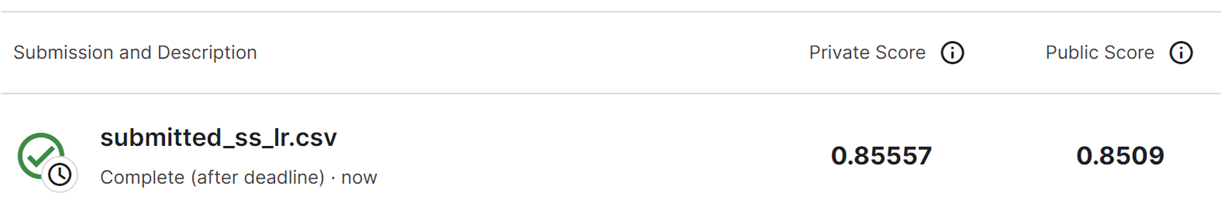

#### 4.2. Random Forest Submission

In [190]:
y_tt_rf = rf_g.predict_proba(X_tt)[:,1]
y_tt_rf = pd.DataFrame(y_tt_rf)
submission['Probability']=y_tt_rf
submission.to_csv('submitted_ss_rf.csv', index=False)
submission.head()

,Id,Probability
0,1,0.082506
1,2,0.041983
2,3,0.016587
3,4,0.090231
4,5,0.139051


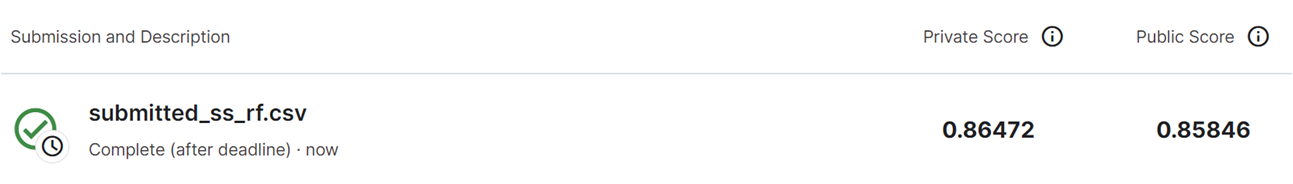

#### 4.3. LightGBM Submission

In [191]:
y_tt_lgbm = lgbm_grid.predict_proba(X_tt)[:,1]
y_tt_lgbm = pd.DataFrame(y_tt_lgbm)
submission['Probability']=y_tt_lgbm
submission.to_csv('submitted_ss_lgbm.csv', index=False)
submission.head()

,Id,Probability
0,1,0.078625
1,2,0.049206
2,3,0.019887
3,4,0.095164
4,5,0.170338


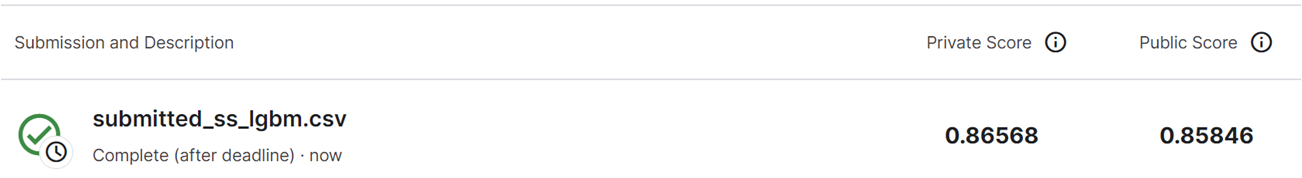

# 5. Leaderboard scores

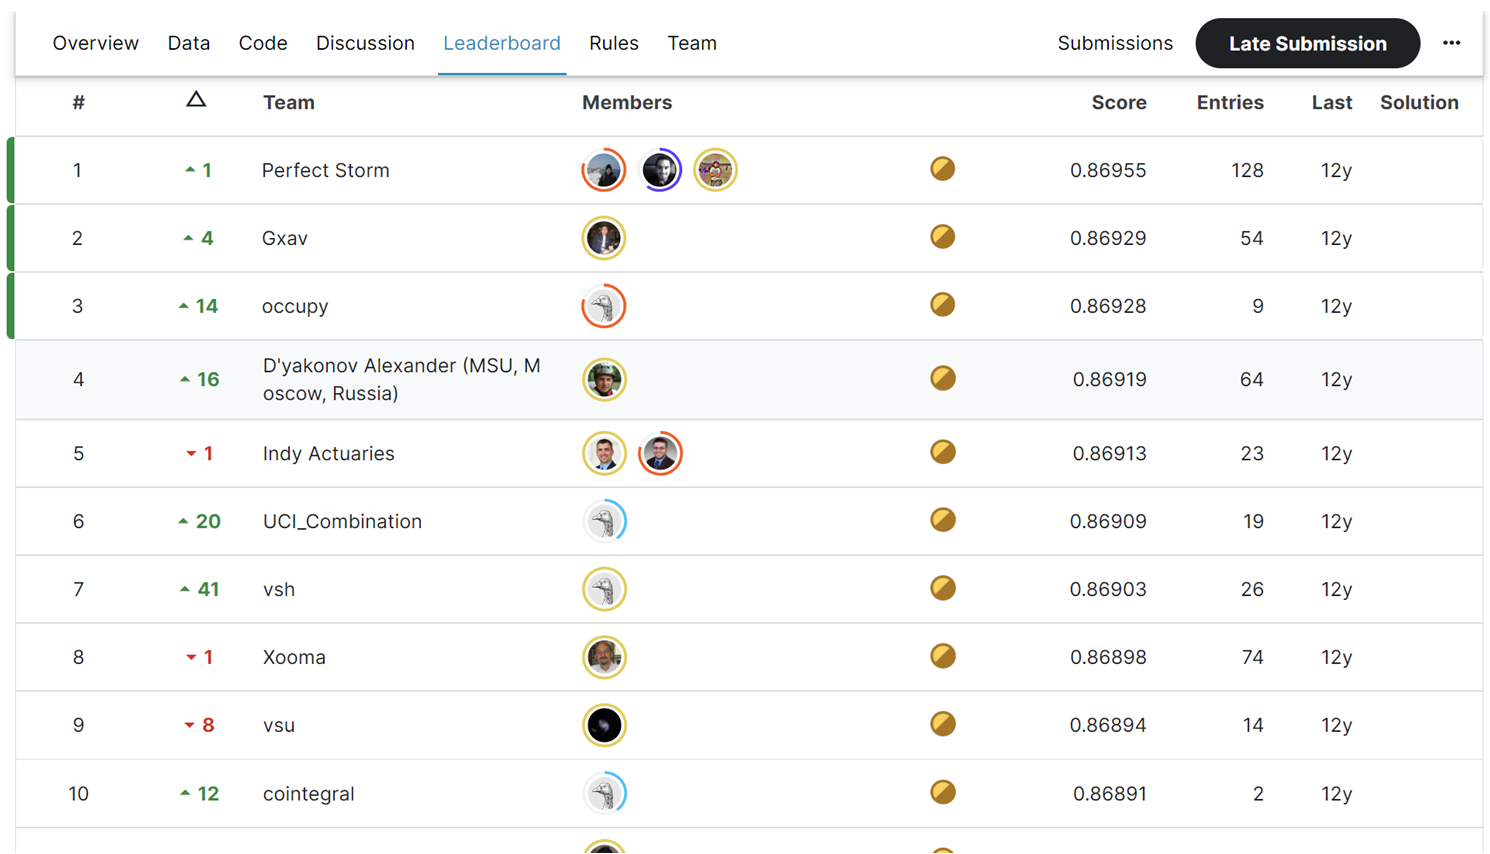